## Лабораторная работа №4. Работа с временным рядом
Данные: цены на момент закрытия на акции компании META

In [142]:
import yfinance as yf

import datetime
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
# оценка качества моделей
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import mean_squared_error

# статистические методы
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# для быстрой обработки пропусков при расчете среднего
from pandas.core.nanops import nanmean as pd_nanmean


# для интерактивного отображения прогресса в расчетах
import tqdm
from tqdm.auto import tqdm

import seaborn as sns
sns.set_theme()

from math import sqrt
import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [143]:
df = yf.Ticker('META').history(interval = "5d", start = '2012-01-01')
df.shape

(552, 7)

In [144]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-05-18 00:00:00-04:00,42.049999,45.000000,38.000000,38.230000,573576400,0.0,0.0
2012-05-23 00:00:00-04:00,31.370001,32.500000,31.360001,32.000000,73600000,0.0,0.0
2012-06-07 00:00:00-04:00,27.000000,27.350000,26.150000,26.309999,26159500,0.0,0.0
2012-06-12 00:00:00-04:00,27.480000,27.770000,26.959999,27.400000,15816800,0.0,0.0
2012-06-22 00:00:00-04:00,32.410000,33.450001,32.060001,33.049999,74834000,0.0,0.0
...,...,...,...,...,...,...,...
2023-03-22 00:00:00-04:00,202.500000,207.369995,199.669998,199.809998,28477800,0.0,0.0
2023-03-27 00:00:00-04:00,204.809998,205.860001,201.360001,202.839996,18527200,0.0,0.0
2023-04-06 00:00:00-04:00,209.250000,216.940002,208.649994,216.100006,26104400,0.0,0.0


In [145]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-05-18 00:00:00-04:00,42.049999,45.000000,38.000000,38.230000,573576400,0.0,0.0
2012-05-23 00:00:00-04:00,31.370001,32.500000,31.360001,32.000000,73600000,0.0,0.0
2012-06-07 00:00:00-04:00,27.000000,27.350000,26.150000,26.309999,26159500,0.0,0.0
2012-06-12 00:00:00-04:00,27.480000,27.770000,26.959999,27.400000,15816800,0.0,0.0
2012-06-22 00:00:00-04:00,32.410000,33.450001,32.060001,33.049999,74834000,0.0,0.0


Оставим данные только на момент закрытия

In [146]:
df = df[['Close']]

In [147]:
df

,Close
Date,
2012-05-18 00:00:00-04:00,38.230000
2012-05-23 00:00:00-04:00,32.000000
2012-06-07 00:00:00-04:00,26.309999
2012-06-12 00:00:00-04:00,27.400000
2012-06-22 00:00:00-04:00,33.049999
...,...
2023-03-22 00:00:00-04:00,199.809998
2023-03-27 00:00:00-04:00,202.839996
2023-04-06 00:00:00-04:00,216.100006


### Построим график временного ряда

<AxesSubplot:title={'center':'Цена на момент закрытия на акции компании'}, xlabel='Date'>

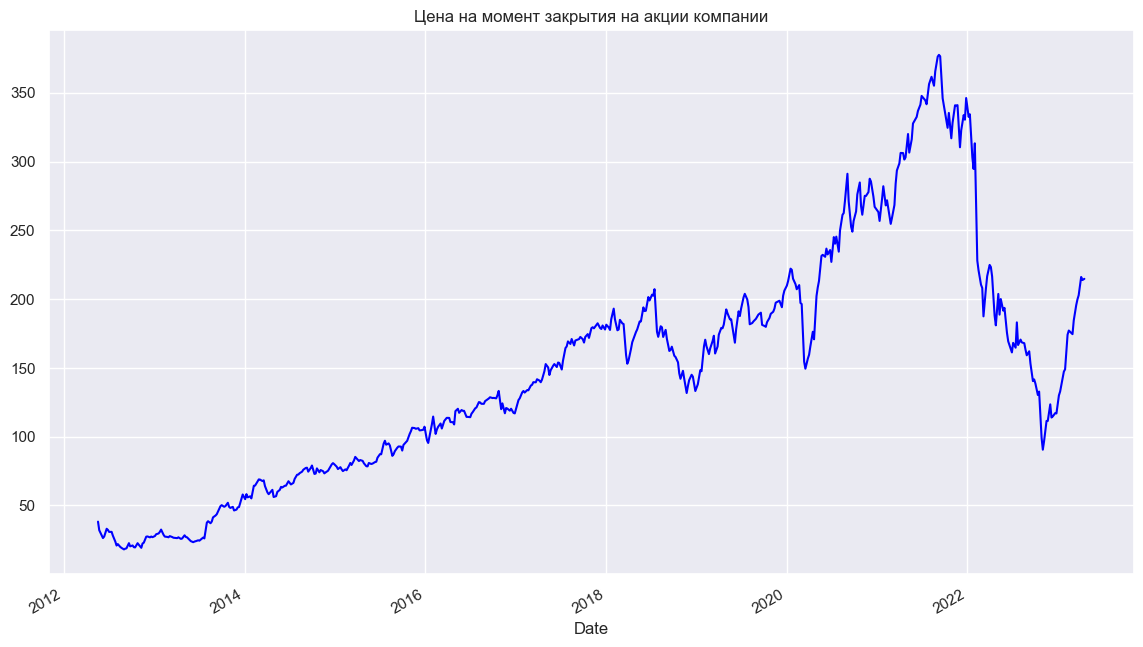

In [148]:
df.Close.plot( figsize=(14,8),title= 'Цена на момент закрытия на акции компании', fontsize=11, color="blue")

По графику нельзя точно сказать стоило или нет вкладыватся в акции компании.
Также мы видим,что ряд не стационарен. В нём можно выразить трендовую зависимость.

График показывает, что цены на акции META в основном исправно с периодичными колебаниями росли до 2022 года. Однако, можно заметить, что дальше происходит резкий обвал акций, но при этом замятны признаки улучшения и исправления критичной ситуации.

### Тест Дикки-Фуллера на стационарность
Проверим на уровне значимости 0.05

In [149]:
def test_stationarity(timeseries, window = 24, cutoff = 0.05):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(15, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.show()
    
    #Perform Dickey-Fuller test:
    # p-value
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values,autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [150]:
sample_data = df.Close

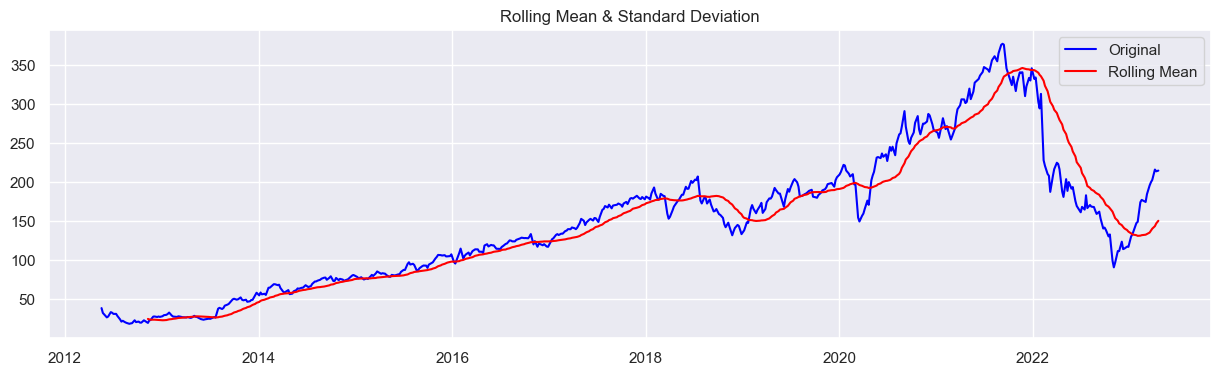

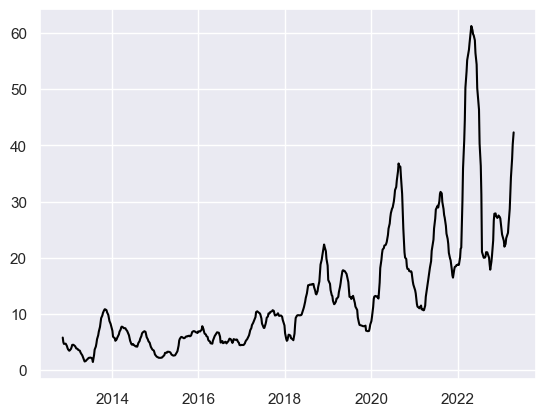

Results of Dickey-Fuller Test:
p-value = 0.4186. The series is likely non-stationary.
Test Statistic                  -1.724301
p-value                          0.418637
#Lags Used                      15.000000
Number of Observations Used    536.000000
Critical Value (1%)             -3.442609
Critical Value (5%)             -2.866947
Critical Value (10%)            -2.569650
dtype: float64


In [151]:
test_stationarity(sample_data)

На основании теста Dickey-Fuller, можно сделать вывод о том, что временной ряд не является стационарным. Это подтверждается большим значением p-value, превышающим уровень значимости 0.05, и недостаточным значением тестовой статистики для отклонения от нулевой гипотезы о нестационарности ряда.

### Методология Бокса-Дженкинса.

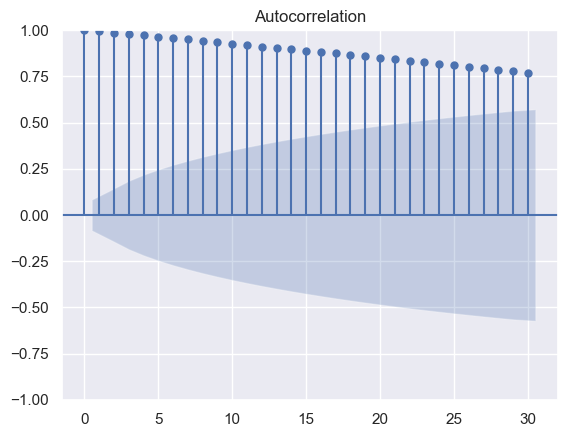

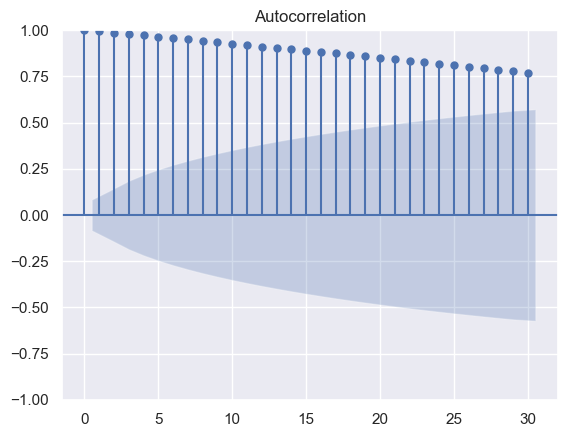

In [152]:
plot_acf(df.Close, lags=30)

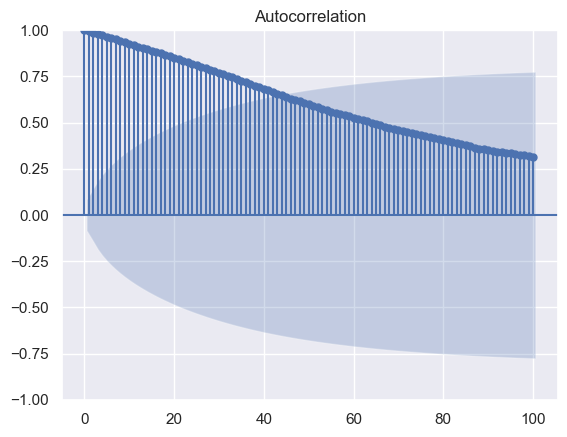

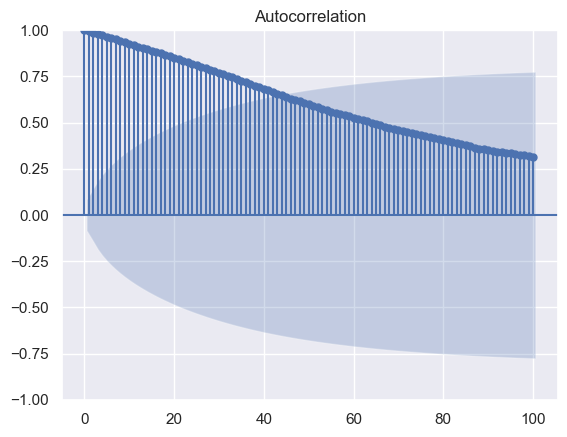

In [153]:
plot_acf(df.Close, lags=100)

Результаты построение PACF и ACF не удовлетворительны. Сложно определить примерные значения p,q для построения ARIMA-модели.
Предлагается для начала избавится от трендовой зависимости

### Удаления линейной трендовой составляющей из временного ряда

In [154]:
df["index"] = range(1, len(df)+1, 1)

In [155]:
from sklearn.linear_model import LinearRegression

X = np.array(df["index"]).reshape((-1, 1))
Y = np.array(df["Close"])

model = LinearRegression().fit(X,Y)
print('Y =', model.coef_[0], '* X +', model.intercept_)
print('coefficient of determination:', model.score(X, Y))

Y = 0.4489157903676541 * X + 23.884512277563672
coefficient of determination: 0.7004855178704036


In [156]:
df["Close_t"] = df["Close"] - (df["index"] * model.coef_[0] + model.intercept_)

In [157]:
df

,Close,index,Close_t
Date,,,
2012-05-18 00:00:00-04:00,38.230000,1,13.896571
2012-05-23 00:00:00-04:00,32.000000,2,7.217656
2012-06-07 00:00:00-04:00,26.309999,3,1.078740
2012-06-12 00:00:00-04:00,27.400000,4,1.719824
2012-06-22 00:00:00-04:00,33.049999,5,6.920908
...,...,...,...
2023-03-22 00:00:00-04:00,199.809998,548,-70.080368
2023-03-27 00:00:00-04:00,202.839996,549,-67.499285
2023-04-06 00:00:00-04:00,216.100006,550,-54.688191


<AxesSubplot:title={'center':'Без тренда'}, xlabel='Date'>

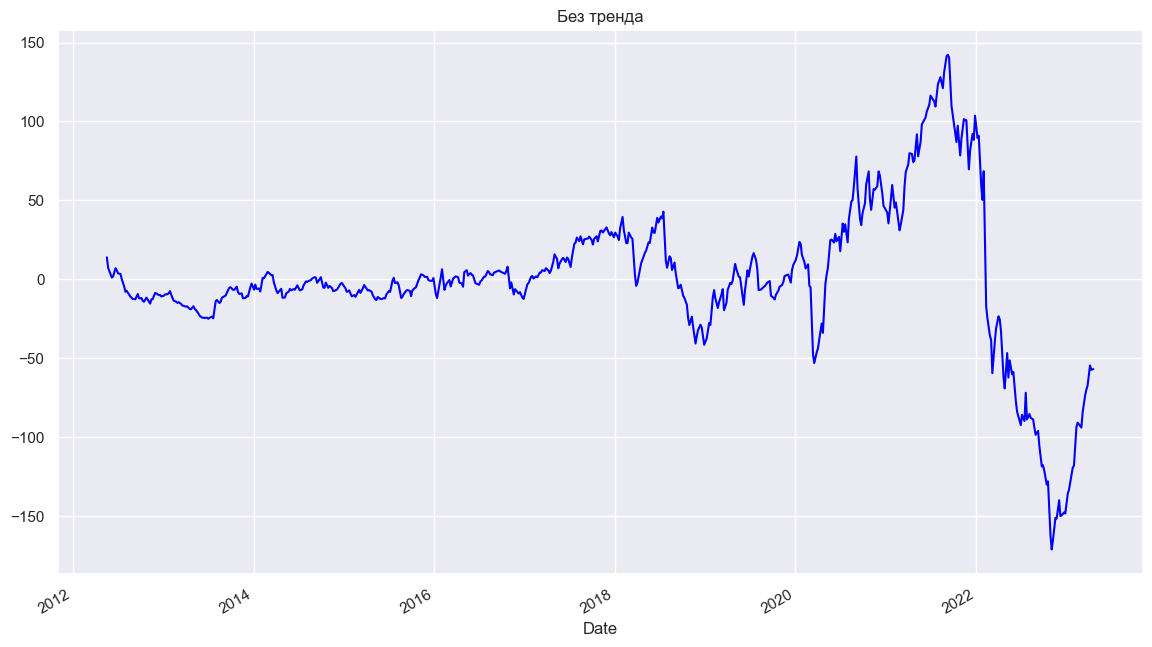

In [158]:
df.Close_t.plot( figsize=(14,8),title= 'Без тренда', fontsize=11, color="blue")

In [159]:
dftest_t = adfuller(df.Close_t, autolag='AIC')

if dftest_t[1] < 0.05:
    print('p-value = %.4f. Ряд вероятно стационарен.' % dftest[1])
else:
    print('p-value = %.4f. Ряд вероятно нестационарен.' % dftest[1])

p-value = 0.4219. Ряд вероятно нестационарен.


Поcле преобразований ряд всё ещё не стационарен.

### Разделим данные

In [160]:
from sklearn. model_selection import train_test_split

train, test = df[0:450], df[450:]
print(train.shape, test.shape)
test

(450, 3) (102, 3)


,Close,index,Close_t
Date,,,
2021-04-06 00:00:00-04:00,306.260010,451,79.914476
2021-04-16 00:00:00-04:00,306.179993,452,79.385543
2021-04-21 00:00:00-04:00,301.470001,453,74.226636
2021-04-26 00:00:00-04:00,303.040009,454,75.347727
2021-05-06 00:00:00-04:00,320.019989,455,91.878792
...,...,...,...
2023-03-22 00:00:00-04:00,199.809998,548,-70.080368
2023-03-27 00:00:00-04:00,202.839996,549,-67.499285
2023-04-06 00:00:00-04:00,216.100006,550,-54.688191


In [161]:
p = range(0,8)
d = range(0,3)
q = range(0,10)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_AIC = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train.Close_t, order = params)
    result_test = model_test.fit()
    if result_test.aic < best_AIC:
        best_params = params
        best_AIC = result_test.aic
print(best_params, best_AIC)

100%|██████████| 240/240 [06:17<00:00,  1.57s/it]

(2, 1, 7) 2878.031458276091


Таким образом на преобразованных данных можно построить модель ARIMA(2,1,7)

In [162]:
p = range(0,8)
d = range(0,3)
q = range(0,10)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_AIC = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train.Close, order = params)
    result_test = model_test.fit()
    if result_test.aic < best_AIC:
        best_params = params
        best_AIC = result_test.aic
print(best_params, best_AIC)

100%|██████████| 240/240 [06:06<00:00,  1.53s/it]

(5, 2, 6) 2883.5596197184864


Таким образом на исзодных данных можно построить модель ARIMA(5,2,6). Она сложнее нежели модель без тренда, однако, даёт лучшие результаты

### Проверим модель на тестовой выборке

In [163]:
test.Close

Date
2021-04-06 00:00:00-04:00    306.260010
2021-04-16 00:00:00-04:00    306.179993
2021-04-21 00:00:00-04:00    301.470001
2021-04-26 00:00:00-04:00    303.040009
2021-05-06 00:00:00-04:00    320.019989
                                ...    
2023-03-22 00:00:00-04:00    199.809998
2023-03-27 00:00:00-04:00    202.839996
2023-04-06 00:00:00-04:00    216.100006
2023-04-11 00:00:00-04:00    213.850006
2023-04-19 00:00:00-04:00    214.750000
Name: Close, Length: 102, dtype: float64

In [164]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [165]:
model_test = sm.tsa.arima.ARIMA(test.Close, order = (5,2,6))
result_test = model_test.fit()
preds = result_test.predict(dynamic=False)

mean_absolute_percentage_error(test.Close, preds)

6.071621681636257

In [166]:
preds

Date
2021-04-06 00:00:00-04:00      0.000000
2021-04-16 00:00:00-04:00    459.383697
2021-04-21 00:00:00-04:00    306.181214
2021-04-26 00:00:00-04:00    299.536366
2021-05-06 00:00:00-04:00    301.260135
                                ...    
2023-03-22 00:00:00-04:00    198.563447
2023-03-27 00:00:00-04:00    204.805694
2023-04-06 00:00:00-04:00    205.906988
2023-04-11 00:00:00-04:00    221.532360
2023-04-19 00:00:00-04:00    214.599982
Name: predicted_mean, Length: 102, dtype: float64

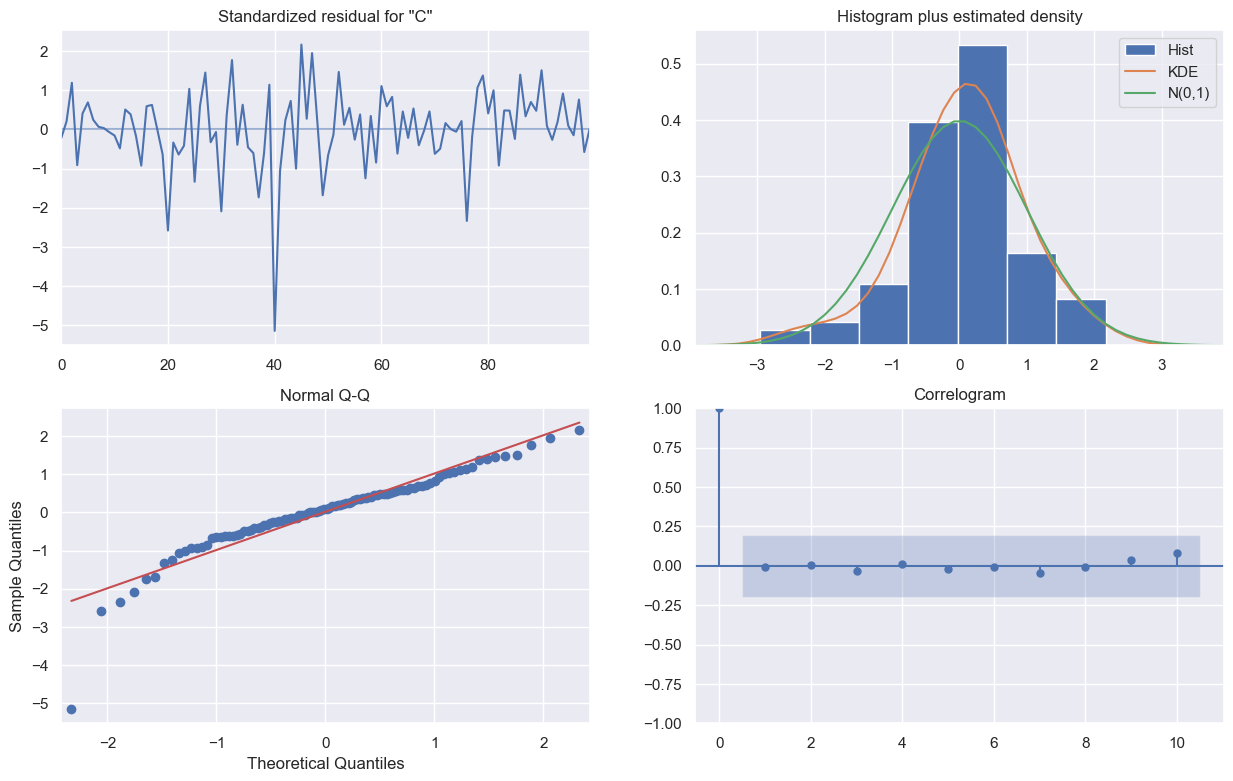

In [170]:
result_test.plot_diagnostics(figsize=(15, 9))
plt.show()


### Построим прогноз

In [171]:
# Получить прогноз на 10 шагов вперёд
pred_uc = result_test.get_forecast(steps=10)
# Получить интервал прогноза
pred_ci = pred_uc.conf_int().reset_index(drop=True)
print(pred_ci)
type(pred_ci)

   lower Close  upper Close
0   192.702102   244.992794
1   188.522285   263.488040
2   174.439585   272.253780
3   169.912492   287.629747
4   166.229974   305.182944
5   155.332157   312.729456
6   152.575774   326.369610
7   146.060422   341.000563
8   139.718398   352.087821
9   135.051233   364.486218


pandas.core.frame.DataFrame

In [172]:
y = pd.Series(test.Close, index=test.index)
y

Date
2021-04-06 00:00:00-04:00    306.260010
2021-04-16 00:00:00-04:00    306.179993
2021-04-21 00:00:00-04:00    301.470001
2021-04-26 00:00:00-04:00    303.040009
2021-05-06 00:00:00-04:00    320.019989
                                ...    
2023-03-22 00:00:00-04:00    199.809998
2023-03-27 00:00:00-04:00    202.839996
2023-04-06 00:00:00-04:00    216.100006
2023-04-11 00:00:00-04:00    213.850006
2023-04-19 00:00:00-04:00    214.750000
Name: Close, Length: 102, dtype: float64

In [173]:
dti = pd.date_range("2023-04-18 00:00:00-04:00", periods=10, freq="5D")
dti

DatetimeIndex(['2023-04-18 00:00:00-04:00', '2023-04-23 00:00:00-04:00',
               '2023-04-28 00:00:00-04:00', '2023-05-03 00:00:00-04:00',
               '2023-05-08 00:00:00-04:00', '2023-05-13 00:00:00-04:00',
               '2023-05-18 00:00:00-04:00', '2023-05-23 00:00:00-04:00',
               '2023-05-28 00:00:00-04:00', '2023-06-02 00:00:00-04:00'],
              dtype='datetime64[ns, pytz.FixedOffset(-240)]', freq='5D')

In [174]:
y_pred = pred_ci.set_index(dti)
y_pred.index.names = ['Date']
y_pred
type(y_pred)

pandas.core.frame.DataFrame

In [175]:
y_pred_mean = pred_uc.predicted_mean
df = pd.DataFrame(y_pred_mean)
df = df.to_numpy()
print(df[:,0])
y_pred_mean_dti = pd.Series(data=df[:,0],index=dti)
y_pred_mean_dti.index.names = ['Date']
y_pred_mean_dti
type(y_pred_mean_dti)

[218.84744778 226.00516249 223.34668264 228.77111971 235.70645921
 234.03080688 239.47269179 243.53049217 245.90310918 249.76872562]


pandas.core.series.Series

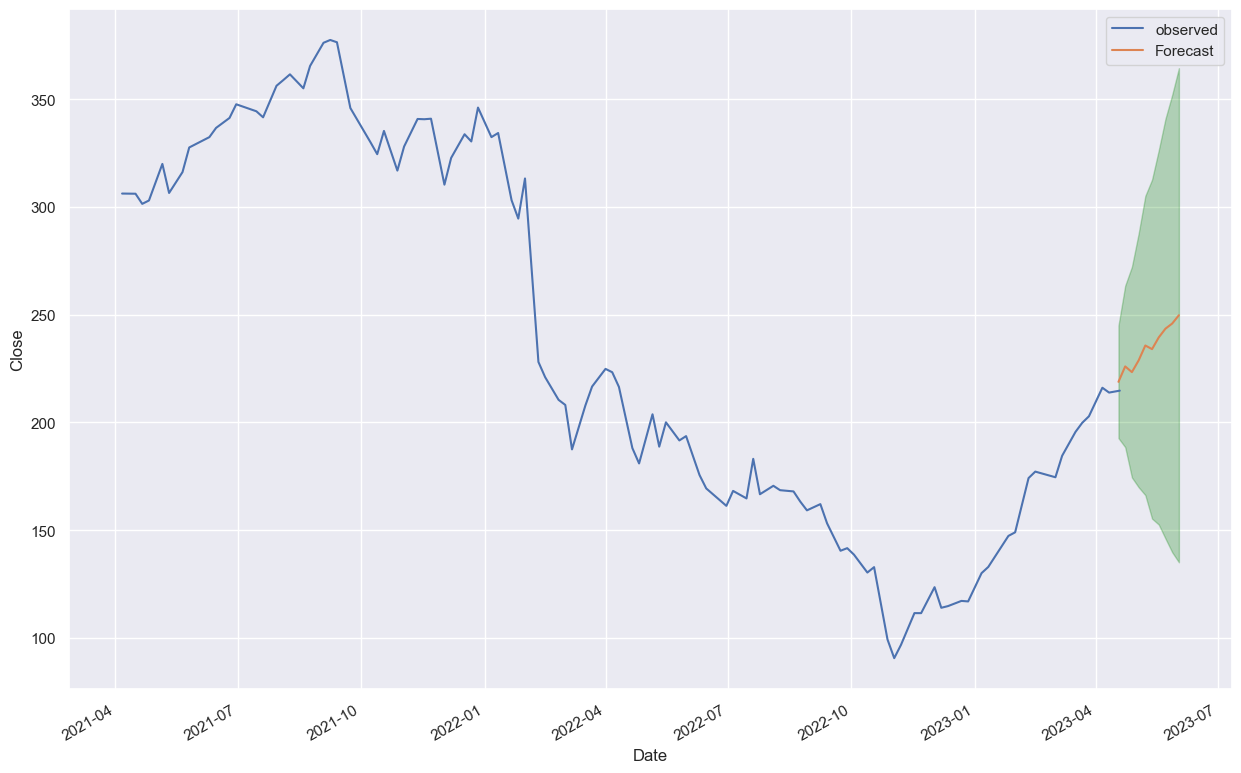

In [179]:
ax = y.plot(label='observed', figsize=(15, 10))
y_pred_mean_dti.plot(ax=ax, label='Forecast')
ax.fill_between(y_pred.index,
y_pred.iloc[:, 0],
y_pred.iloc[:, 1], color='green', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.legend()
plt.show()

Судя по графику, в дальнейшем цены на акции этой компании продолжат возрастать.

### Построение моделей для прогноза по разным периодам

In [181]:
df = yf.Ticker('META').history(interval = "5d", start = '2012-01-01')
df = df[['Close']]

<AxesSubplot:title={'center':'Цена закрытия акции'}, xlabel='Date'>

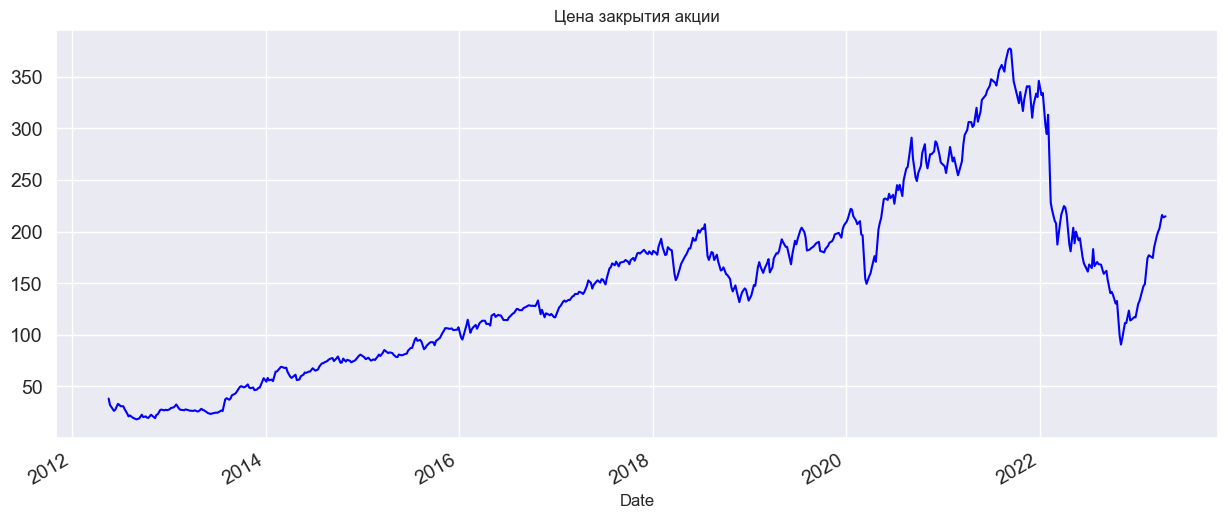

In [192]:
df.Close.plot( figsize=(15,6),title= 'Цена закрытия акции', fontsize=14, color="blue")

## Дополнительное задание
Требуется разделить исходные данные на 3 блока
Предлагается взять такие интервалы:

1) Начало - середина 2018 

2) середина 2018 - середина 2020

3) 2020 - конец

In [185]:
df_1 = df.index < '2018-06-01 00:00:00-04:00'
df_1 = df.loc[df_1]
df_1

,Close
Date,
2012-05-18 00:00:00-04:00,38.230000
2012-05-23 00:00:00-04:00,32.000000
2012-06-07 00:00:00-04:00,26.309999
2012-06-12 00:00:00-04:00,27.400000
2012-06-22 00:00:00-04:00,33.049999
...,...
2018-04-27 00:00:00-04:00,173.589996
2018-05-02 00:00:00-04:00,176.070007
2018-05-07 00:00:00-04:00,177.970001


In [186]:
df_2 = df.query("index >= '2018-06-01 00:00:00-04:00' & index < '2020-06-01 00:00:00-04:00'")
df_2

,Close
Date,
2018-06-01 00:00:00-04:00,193.990005
2018-06-06 00:00:00-04:00,191.339996
2018-06-11 00:00:00-04:00,191.539993
2018-06-21 00:00:00-04:00,201.500000
2018-06-26 00:00:00-04:00,199.000000
...,...
2020-05-01 00:00:00-04:00,202.270004
2020-05-06 00:00:00-04:00,208.470001
2020-05-11 00:00:00-04:00,213.179993


In [187]:
df_3 = df.query("index > '2020-06-01 00:00:00-04:00'")
df_3

,Close
Date,
2020-06-05 00:00:00-04:00,230.770004
2020-06-10 00:00:00-04:00,236.729996
2020-06-15 00:00:00-04:00,232.500000
2020-06-25 00:00:00-04:00,235.679993
2020-06-30 00:00:00-04:00,227.070007
...,...
2023-03-22 00:00:00-04:00,199.809998
2023-03-27 00:00:00-04:00,202.839996
2023-04-06 00:00:00-04:00,216.100006


### Разделим выборку на тестовую и обучающую

In [188]:
train_1, test_1 = df_1[0:270], df_1[270:]
train_2, test_2 = df_2[0:90], df_2[90:]
train_3, test_3 = df_3[0:125], df_3[125:]

In [189]:
p = range(0,5)
d = range(0,5)
q = range(0,10)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_AIC = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train_1.Close, order = params)
    result_test = model_test.fit()
    if result_test.aic < best_AIC:
        best_params = params
        best_AIC = result_test.aic
        
model_test = sm.tsa.arima.ARIMA(test_1.Close, order = best_params)
result_test = model_test.fit()
print('Best model on 1 block:', best_params, 'mape на train:',best_AIC, 'mape на test:', result_test.aic)

100%|██████████| 250/250 [03:59<00:00,  1.04it/s]


Best model on 1 block: (2, 2, 1) mape на train: 1379.7421955958805 mape на test: 219.92362304705574


In [190]:
p = range(0,5)
d = range(0,5)
q = range(0,10)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_AIC = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train_2.Close, order = params)
    result_test = model_test.fit()
    if result_test.aic < best_AIC:
        best_params = params
        best_AIC = result_test.aic
        
model_test = sm.tsa.arima.ARIMA(test_2.Close, order = best_params)
result_test = model_test.fit()
print('Best model on 1 block:', best_params, 'mape на train:',best_AIC, 'mape на test:', result_test.aic)

100%|██████████| 250/250 [02:14<00:00,  1.86it/s]

Best model on 1 block: (2, 1, 2) mape на train: 601.4384319629658 mape на test: 109.69056871953032


In [191]:
p = range(0,5)
d = range(0,5)
q = range(0,10)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_AIC = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train_3.Close, order = params)
    result_test = model_test.fit()
    if result_test.aic < best_AIC:
        best_params = params
        best_AIC = result_test.aic
        
model_test = sm.tsa.arima.ARIMA(test_3.Close, order = best_params)
result_test = model_test.fit()
print('Best model on 1 block:', best_params, 'mape на train:',best_AIC, 'mape на test:', result_test.aic)

100%|██████████| 250/250 [02:41<00:00,  1.55it/s]

Best model on 1 block: (0, 2, 1) mape на train: 1005.9922074644224 mape на test: 126.12371417465214


Из результатов моделирования видно, что лучшая модель на первом блоке данных имеет порядок (2,2,1) и достигает AIC на тренировочной выборке в размере 1379.7422, а на тестовой - 219.9236. Лучшая модель на втором блоке данных имеет порядок (2,1,2) и достигает AIC на тренировочной выборке в размере 601.4384, а на тестовой - 109.691. Лучшая модель на третьем блоке данных имеет порядок (0,2,1) и достигает AIC на тренировочной выборке в размере 1005.9922, а на тестовой - 126.1237.

Модель с наименьшим значением AIC на тестовой выборке является наиболее предпочтительной для прогнозирования будущих значений. Следовательно, на основе результатов моделирования можно сделать вывод, что наиболее точная модель на тестовой выборке была построена на втором блоке данных и имеет порядок (2,1,2). 